# SmartRev: Navigate Pet Food Reviews Smartly

## Table of Content:
* [A. Introduction](#A)
    * [I. Import Libraries](#A.I)
    * [II. Pet Food Expenditures](#A.II)
* [B. Datasets](#B)
    * [I. Amazon Customer Reviews Dataset for Pet Products](#B.I)
    * [II. Chewy Reviews Dataset](#B.II)
* [C. Preprocess Data](#C)
* [D. Modeling](#D)
    * [I. Unsupervised Learning: Extract Topics From Reviews](#D.I)
        * [1. Tokenizing Sentences](#D.I.1)
        * [2. Bag of words on the dataset](#D.I.2)
        * [3. TF-IDF (Term Frequency-Inverse Document Frequency)](#D.I.3)
        * [4. Selecting Number of Topics](#D.I.4)
        * [5. Running LDA](#D.I.5)
    * [II. Supervised Learning](#D.II)
        * [1. Create Dictionary of Words for each Topic](#D.II.1)
        * [2. EDA](#D.II.2)
        * [3. Create Train and Eval Files](#D.II.3)
        * [4. Create Python Package for Training the Model](#D.II.4)
        * [5. TEST RUN](#D.II.5)
        * [6. Train on Cloud](#D.II.6)
            * [i. CNN Model](#D.II.6.i)
            * [LSTM Model](#D.II.6.ii)
            * [iii. Bidirectional LSTM Model](#D.II.6.iii)
        * [7. Deploy Model](#D.II.7)
        * [8. Prediction](#D.II.8)
* [E. Test the Dictionary on New Dataset](#E)   

<a id="A">

## A. Introduction

The problem at hand is whether we can classify critical reviews on pet food online into different topics, for instance health, quality and customer service.

We'll start by using "Amazon Customer Reviews Dataset" for pet products available here (https://s3.amazonaws.com/amazon-reviews-pds/readme.html), as well as scraping critical pet food reviews (those with 3 stars or less) from Chewy's website.

The dataset then needs to be pre-processed before feeding it to any model.

Two approaches are taken to this problem:
1. **Unsupervised learning**, for which [LDA and TF-IDF](#LDA) have been adopted.
2. **Supervised Learning**, where each review is first given a label using a dictionary of key words for each topic, and then used in [classifiers](#train).

<a id="A.I">

### I. Importing Libraries

Let's start by loading the required libraries, as well as setting up a project and bucket configuration on GCP.

In [5]:
BUCKET = 'petfood_review'  
PROJECT = 'petfoodrecommend'    
REGION = 'us-central1'  

In [6]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [119]:
import pandas as pd
import numpy as np
np.random.seed(2020)
import datetime, os
import re
import time


import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
print('TensorFlow Version: {}'.format(tf.__version__))


import gensim
from gensim.utils import lemmatize, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm

import pyLDAvis.gensim

import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')


import chart_studio
# *fill in username and API Key for plotly here*
chart_studio.tools.set_credentials_file(username='MelissaKR', api_key='rpgCYqSrBtBrTIbbMaV8')
import chart_studio.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
import matplotlib.colors as mcolors


import requests
import math
import textwrap
import os
from bs4 import BeautifulSoup
from collections import defaultdict 


from google.cloud import storage
import warnings
warnings.filterwarnings('ignore')

TensorFlow Version: 1.15.2


[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id="A.II">

### II. Pet Food Expenditures

According to American Pet Products Associations, americans spent about \$72 Billion dollors on their pets in 2018, with pet food comprising almost half of it. Also, this trend has been increasing over the years. 
(https://www.americanpetproducts.org/press_releasedetail.asp?id=191)

In [349]:
APPA = {'Pet Food':[29.07, 30.32, 31.68],
'Veterinary Care':[17.07, 18.11, 18.98],
'Year':["2017","2018","2019"]}

APPA_df = pd.DataFrame.from_dict(APPA)

In [341]:
APPA_df.dtypes

Pet Food           float64
Veterinary Care    float64
Year                object
dtype: object

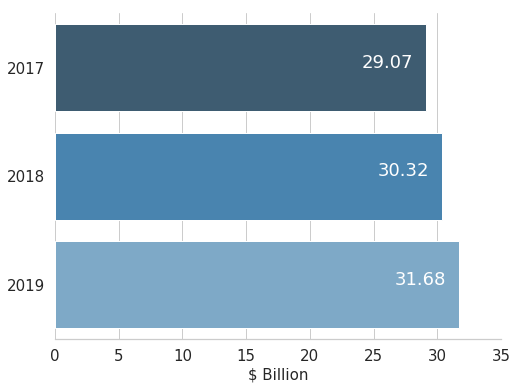

In [394]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Plot the total crashes
sns.color_palette("PuBuGn_d")
p = sns.barplot(APPA_df["Pet Food"], y = ['year1', 'year2','year3'],  palette="Blues_d")

# Add a legend and informative axis label
ax.set(xlim=(0, 35), ylabel="",
       xlabel="$ Billion")
ax.set_xlabel("$ Billion", fontsize=15)
ax.set(yticklabels=["2017","2018", "2019"])
sns.despine(left=True)

for b in p.patches:
    width = b.get_width()
    ax.text(width -1  ,
            b.get_y()+b.get_height()/2.,
            '{:1.2f}'.format(width),
            ha="right", fontsize=18, color="white")
        
p.tick_params(labelsize=15)
p.figure.savefig("Appa_new.png")

<a id="B">

## B. Datasets

<a id="B.I">

### I. Amazon Customer Reviews Dataset for Pet Products

After transferring the dataset from an S3 bucket on AWS to GCS(Google Cloud Storage), we'll need to separate pet food from the rest of the pet products and critical reviews from the rest.

In [13]:
filename = 'gs://{0}/amazon_reviews_us_Pet_Products_v1_00.tsv'.format(BUCKET)
amazon_df = pd.read_csv(filename, delimiter = '\t', error_bad_lines=False)

b'Skipping line 21404: expected 15 fields, saw 22\nSkipping line 31839: expected 15 fields, saw 22\nSkipping line 37779: expected 15 fields, saw 22\nSkipping line 38344: expected 15 fields, saw 22\nSkipping line 61449: expected 15 fields, saw 22\n'
b'Skipping line 80975: expected 15 fields, saw 22\nSkipping line 85603: expected 15 fields, saw 22\nSkipping line 95950: expected 15 fields, saw 22\nSkipping line 105132: expected 15 fields, saw 22\nSkipping line 115378: expected 15 fields, saw 22\n'
b'Skipping line 152632: expected 15 fields, saw 22\nSkipping line 159310: expected 15 fields, saw 22\nSkipping line 162724: expected 15 fields, saw 22\nSkipping line 168588: expected 15 fields, saw 22\nSkipping line 170412: expected 15 fields, saw 22\nSkipping line 187169: expected 15 fields, saw 22\n'
b'Skipping line 205461: expected 15 fields, saw 22\nSkipping line 210928: expected 15 fields, saw 22\nSkipping line 213691: expected 15 fields, saw 22\nSkipping line 228697: expected 15 fields, sa

Let's take a look at what we have:

In [14]:
amazon_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,28794885,REAKC26P07MDN,B00Q0K9604,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,5.0,0.0,0.0,N,Y,"A great purchase for ""dribbly"" dogs",Best belly bands on the market! These are a g...,2015-08-31
1,US,11488901,R3NU7OMZ4HQIEG,B00MBW5O9W,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,2.0,0.0,1.0,N,Y,My dogs love Hugs and Kisses,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,43214993,R14QJW3XF8QO1P,B0084OHUIO,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,5.0,0.0,0.0,N,Y,I have been purchasing these for a long time. ...,I have been purchasing these for a long time. ...,2015-08-31
3,US,12835065,R2HB7AX0394ZGY,B001GS71K2,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,5.0,0.0,0.0,N,Y,it is easy to open and close,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,26334022,RGKMPDQGSAHR3,B004ABH1LG,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,5.0,0.0,0.0,N,Y,Dog crate,Worked really well. Very pleased with my purc...,2015-08-31


We can see that this dataset is for all pet products, which is not limited to pet food, as well as reviews for all star ratings.

In [54]:
amazon_df.dtypes

marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent         int64
product_title         object
product_category      object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
dtype: object

<a id="B.II">

### II. Chewy Reviews Dataset

We'll then scrape critical reviews for pet food from Chewy's website uisng **BeautifulSoup** library to augment our dataset. Critical reviews are those with ratings of 3 stars or less. 

In [33]:
def get_soup(url):
    '''
    Input: url of the website that is being scraped.
    Output: html contents of the website using its url.
    '''
    
    out = requests.get(url)
    soup = BeautifulSoup(out.content, 'lxml')

    return soup

def get_products(pet_url):
    '''
    Input: url of the search page for pet food
    Output: list of links to specific products shown on each page
    '''
    href_list = []
    
    for page_number in range(1,12):
        if page_number == 1:
            so = get_soup(pet_url)
        else:
            pet_url_page = pet_url + "&page={}".format(page_number)
            so = get_soup(pet_url_page)

        product_list = so.find_all('article', {'class': 'product-holder js-tracked-product cw-card cw-card-hover'})

        for product in product_list:
            href = product.find(attrs={'class':'product'})
            link = href.get('href')
            href_list.append(link)
    
    return href_list


def get_item_id(url):
    '''
    This function extracts the item id and product name that appear in the url
    of a specific pet food.
    '''
    item_id = re.findall("/dp/(\d+)", url)
    product_name = re.findall("/(.*)/dp", url)
    
    return item_id[0], product_name[0].split('/')[0]


def get_product_reviews_url(item_id, product_name, page_number=None):
    '''
    Given the item id and product name of a secific pet food, this function outputs
    the url directing to the critical review.
    '''
    if not page_number:
        page_number = 1
    BASE_URL = 'https://www.chewy.com'

    return BASE_URL + '/{}/product-reviews/{}'\
                    '?reviewSort=NEWEST&reviewFilter=NEGATIVE&pageNumber={}'.format(product_name,item_id, page_number)


def get_reviews(request_url):
    '''
    Given the url of a review page, this function outputs review ids, body of the reviews, 
    and their helpful vote counts.
    '''
    products = get_products(request_url)
    
    total_reviews = []

    for link in products:
        item_id, product_name = get_item_id(link)
        reviews = list()
        if item_id is None:
            return reviews
    
        product_reviews_link = get_product_reviews_url(item_id, product_name)

        so = get_soup(product_reviews_link)
    
        max_page_number = so.find(attrs={"class":"ugc-list__content--pagination"})
        if max_page_number is None:
            break
        else:
            if len(max_page_number.text.strip().split()) < 4:
                break
            else:
                max_page_number = max_page_number.text.strip().split()[3]

    
        if max_page_number is None:
            return reviews
    
        max_page_number = int(max_page_number) if max_page_number else 1
        max_page_number *= 0.1  # displaying 10 results per page. So if 663 results then ~66 pages.
        max_page_number = math.ceil(max_page_number)

    
        for page_number in range(1, max_page_number + 1):

            if page_number >=1:
                product_reviews_link = get_product_reviews_url(item_id,product_name,page_number)
                so = get_soup(product_reviews_link)

            reviews_list = so.find_all('li', {'itemprop': 'review'})
        
            if len(reviews_list) == 0:
                break
            
            for review in reviews_list:

                body = review.find(attrs={'class':'ugc-list__review__display'}).text.strip()
                rev_id = review.get('data-content-id')
                try:
                    helpful = review.find(attrs={'data-ga-action':'like'}).text.strip()
                except:
                    helpful = '0'
                
                reviews.append({'id':rev_id, 'body': body, 'helpful_votes':helpful})
            total_reviews.extend(reviews)

    return total_reviews

Let's scrape the first 11 pages for dog, cat and bird food:

In [41]:
links = {'dog food': 'https://www.chewy.com/s?rh=c%3A288%2Cc%3A332',
         'cat food': 'https://www.chewy.com/s?rh=c%3A325%2Cc%3A387',
         'bird food': 'https://www.chewy.com/s?rh=c%3A941%2Cc%3A942'}

total_reviews = []
for key, link in links.items():
    print(key)
    total_reviews.extend(get_reviews(link))

cat food
dog food
bird food


Let's reformat this dataset to a Pandas DataFrame.

In [47]:
chewy_df = pd.DataFrame(total_reviews)

In [48]:
print("A total of {} reviews were scraped from Chewy".format(len(chewy_df)))

A total of 14679 reviews were scraped from Chewy


<a id="C">

## C. Preprocess Data

We first need to clean up the body of the the reviews. This process includes getting rid of non_ASCII characters, html and css-specific signs, as well as stopwords from the reviews, which **clean_text** function takes care of.

This also involves separating pet food from the rest of the pet products, as well as critical reviews from the other reviews for the Amazon dataset. The function **clean_df** does just that.



In [59]:
def clean_amazon(df):
    print('The original length of the dataframe is {}'.format(len(df)))
    
    ### Drop rows with null values if review_body is missing
    if df.isnull().sum()['review_body'] > 0:
        df.dropna(inplace=True)
    
    ### Only consider reviews for verified purchases
    df = df.loc[df['verified_purchase']=='Y']
    
    ### Convert star rating from float to int
    df['star_rating'] = df['star_rating'].astype('int64')
    
    ### Separate Pet Food from the rest of the Pet Products
    df['product_title'] = df['product_title'].str.lower()
    df_new = df[df['product_title'].str.contains("friskies|treat|\
    food|purina|royal canin|meow mix|pro plan|gourmet|fancy feast|\
    blue buffalo|nutrition|science hill|diet")==True]
    
    df_new.drop_duplicates(inplace=True)
    df_new.reset_index(inplace = True)
    df_new.drop('index', axis=1)
    
    print('The final length of the dataframe is {}'.format(len(df_new)))
    
    return df_new

def clean_text(text, remove_stopwords = False):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    contractions = { 
    "ain't": "am not","aint": "am not",
    "aren't": "are not","arent": "are not",
    "can't": "cannot","cant": "cannot",
    "can't've": "cannot have","cant've": "cannot have",
    "'cause": "because",
    "could've": "could have","couldve": "could have",
    "couldn't": "could not","couldnt": "could not",
    "couldn't've": "could not have","couldnt've": "could not have",
    "didn't": "did not","didnt": "did not",
    "doesn't": "does not","doesnt": "does not",
    "don't": "do not","dont": "do not",
    "hadn't": "had not","hadnt": "had not",
    "hadn't've": "had not have","hadnt've": "had not have",
    "hasn't": "has not","hasnt": "has not",
    "haven't": "have not","havent": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would","id": "i would",
    "i'll": "i will",
    "i'm": "i am","im": "i am",
    "i've": "i have","ive": "i have",
    "isn't": "is not","isnt": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not","mustnt": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is","thats": "that is",
    "there'd": "there had",
    "there's": "there is","theres": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
    }
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [56]:
amazon_df_new = clean_amazon(amazon_df)

The original length of the dataframe is 2639853
The final length of the dataframe is 200204


Since we are focusing on negative reviews, let's separate those with 3 stars or less.

In [60]:
df_neg = amazon_df_new[amazon_df_new['star_rating']<4]
df_neg['process_review'] = df_neg['review_body'].apply(clean_text)
df_neg.reset_index(inplace=True)
df_neg.drop('index', axis=1, inplace=True)

Let's clean the body of the reviews from Chewy as well:

In [65]:
chewy_df['process_review'] = chewy_df['body'].apply(clean_text)
chewy_df.reset_index(inplace=True)
chewy_df.drop('index', axis=1, inplace=True)

In [66]:
chewy_df.to_csv('chewy_df.tsv',header=1,index=False, encoding='utf-8', sep='\t')

In [71]:
chewy_df = pd.read_csv('chewy_df.tsv',sep = '\t', error_bad_lines=False)

Finally, we need to merge the Amazon and Chewy datasets.

In [72]:
rev_df = df_neg['process_review']
chewy_revs = chewy_df['process_review']

rev_df = rev_df.append(chewy_revs)
rev_df = rev_df.to_frame()

rev_df.reset_index(inplace=True)
rev_df.drop('index', axis=1, inplace=True)

<a id="D">

## D. Modeling

<a id="D.I">

## I. Unsupervised Learning: Extract Topics From Reviews

The first approach that has been taken to the modeling aspect of the problem is unsupervised learning. The goal is to structure a model that can extract and cluster the different topics from all the reviews.

Latent Dirichlet Allocation (LDA) is one of the most popular topic modelling techniques. It's a probabilistic model for discovering the bastract topics in a word document by estimating probability distributions for topics in the document and words in topics.

There are different steps involved in carrying out topic modeling with LDA:

1. Tokenizing and Lemmatizing sentences, which includes getting rid of words with certain parts of speech, for example pronouns, as well as reducing words to their root, using **gensim** and **nltk** libraries.
2. Building the topic model 
3. Optimizing the number of topics in the model

<a id="D.I.1">

### 1. Tokenizing Sentences 

The processed data represents each document in the corpus as a list of words. First, we need to convert sentences to lists of words, and then lemmatize them, i.e. strip them down to their roots, and omit stop words that have no contextual meanings.

In [149]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [150]:
reviews_processed = rev_df['process_review'].map(preprocess)

<a id="D.I.2">

### 2. Bag of words on the dataset

LDA does not care about the order of the words in the document. Usually, LDA uses the bag-of-words feature representation to represent a document.

We'll create a dictionary of words using **gensim**, and generate a corpus of words that indicate what word appeared how many times in a text.

In [151]:
def LDA_initialize(doc):
    print("Creating Dictionary:")
    dictionary = gensim.corpora.Dictionary(doc)
    print("Number of words:", len(dictionary))
    dictionary.filter_extremes(no_below=15, no_above=0.60)
    print("Number of words after filtering:", len(dictionary))
    
    print("Creating Corpus...")
    bow_corpus = [dictionary.doc2bow(text) for text in doc]
    
    return dictionary, bow_corpus

In [152]:
dictionary, bow_corpus = LDA_initialize(processed_reviews)

Creating Dictionary:
Number of words: 14088
Number of words after filtering: 2815
Creating Corpus...


Let's see an example of how the bag-of-words works. It basically tells us how many times each word that has been tokenized and lemmatized repeats in the document.

In [132]:
example = bow_corpus[2000]

for i in range(len(example)):
    print("Word {} (\"{}\") appears {} time.".format(example[i][0], 
                                                     dictionary[example[i][0]], 
                                                     example[i][1]))

Word 2 ("buy") appears 1 time.
Word 4 ("love") appears 1 time.
Word 12 ("disappoint") appears 1 time.
Word 40 ("break") appears 1 time.
Word 56 ("eventu") appears 1 time.
Word 69 ("littl") appears 1 time.
Word 132 ("long") appears 1 time.
Word 157 ("nice") appears 1 time.
Word 182 ("work") appears 1 time.
Word 274 ("insid") appears 1 time.
Word 343 ("last") appears 1 time.
Word 344 ("longer") appears 2 time.
Word 442 ("cost") appears 1 time.


<a id="D.I.3">

### 3. TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF is a statistical measure that is used to evaluate the importance of a given word to a document in a corpus. A word is more important if the number of times a word appears in the document increases but deemed less important if it has a high frequency of appearing in the corpus. We can use this metric in conjuction with the LDA bag of words dictionary.

In [163]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

<a id="D.I.4">

### 4. Selecting Number of Topics

There are two techniques for evaluating topic models:

#### 1. Perplexity 

Perplexity of a model measures how surprised will be on a new dataset, which is measured as the normalized log-likelihood of the test set. A better model tends to have a lower perplexity measure.
The log-likelihood is basically the probability of observing some unseen data given a trained model, thus measuring how much the model captures the distribution of the held out set. However, there are studies that have shown that perplexity is not a strong measure of human judgment.

#### 2. Topic coherence

Coherence of a topic is the measure of the degree of semantic similarity between its high scoring words, therefore, it helps distinguish between topics that are human interpretable versus those that are artifacts of statistical inference. It computes pairwise scores for each of the selected words and aggregates all the pairwise scores to calculate the coherence score for a particular topic:

$$Coherence = \sum\limits_{i<j} score(W_i, W_j)$$

Therefore, we will use topic Coherence as the measure to choose the optimum number of topics in a document. We run the LDA model with different topic numbers and choose the one with the highest coherence score.

In [156]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,21)
for num_topics in tqdm(num_topics_list):
    lda= Lda(bow_corpus, num_topics=num_topics,id2word = dictionary, 
             passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=bow_corpus, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=bow_corpus,
                           texts=reviews_processed, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())

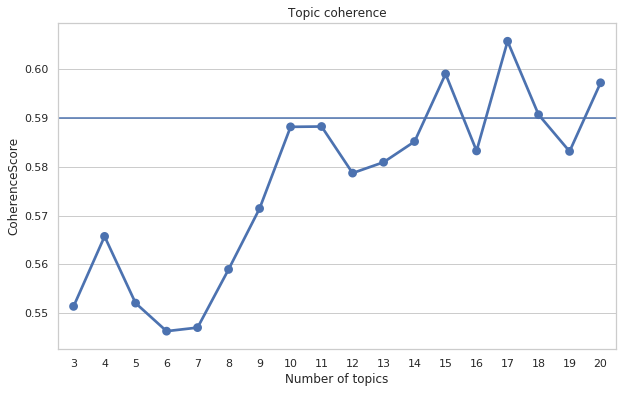

In [162]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_cv})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("whitegrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=0.59)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

We can see that coherence scores for different number of topics plateaus at around 10 topics. Therefore, we'll continue building our LDA model with 10 topics.

<a id="D.I.5">

### 5. Running LDA

Let's assume there are 3 latent topics in the text and find out what words are most associated with each topic.

In [165]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics=10, 
                                             id2word=dictionary, 
                                             passes=20,
                                             chunksize=4000,
                                             workers=4,
                                             random_state=41)

lda_model_tfidf.save('lda_model_tfidf')
dictionary.save('dictionary')
corpora.MmCorpus.serialize('corpus_tfidf.mm', corpus_tfidf)

In [166]:
Lda = models.LdaMulticore
lda=Lda.load('lda_model_tfidf')
dictionary = corpora.Dictionary.load('dictionary')
corpus_tfidf = corpora.MmCorpus('corpus_tfidf.mm')

lda.show_topics()

[(0,
  '0.023*"can" + 0.018*"open" + 0.016*"dent" + 0.010*"journey" + 0.010*"packag" + 0.010*"food" + 0.009*"arriv" + 0.008*"order" + 0.008*"damag" + 0.008*"product"'),
 (1,
  '0.034*"smell" + 0.018*"dog" + 0.016*"love" + 0.013*"like" + 0.013*"puppi" + 0.012*"stick" + 0.011*"food" + 0.009*"bulli" + 0.009*"odor" + 0.009*"terribl"'),
 (2,
  '0.018*"treat" + 0.016*"chew" + 0.013*"small" + 0.012*"minut" + 0.011*"piec" + 0.009*"ball" + 0.009*"hard" + 0.009*"dog" + 0.009*"break" + 0.008*"size"'),
 (3,
  '0.016*"order" + 0.015*"price" + 0.014*"product" + 0.011*"store" + 0.010*"food" + 0.010*"chewi" + 0.009*"receiv" + 0.009*"amazon" + 0.009*"purchas" + 0.008*"ship"'),
 (4,
  '0.021*"work" + 0.018*"flea" + 0.013*"product" + 0.011*"china" + 0.009*"help" + 0.008*"food" + 0.008*"week" + 0.008*"sick" + 0.007*"dog" + 0.007*"problem"'),
 (5,
  '0.029*"food" + 0.022*"picki" + 0.021*"away" + 0.018*"walk" + 0.016*"like" + 0.015*"cat" + 0.015*"eat" + 0.014*"eater" + 0.013*"refus" + 0.012*"tri"'),
 (6,
  

Let's order the topics in decreasing order of coherence score.

In [179]:
# This orders the topics in the decreasing order of coherence score
a = lda.show_topics(num_topics=10,formatted=False,num_words=10)
b = lda.top_topics(corpus_tfidf,dictionary=dictionary,topn=10)

topic_revb = {}
topic_csb = {}
topic_reva = {}
topic_csa = {}
num_topics =lda.num_topics
cnt =1

for ws in b:
    wset = set(w[1] for w in ws[0])
    topic_revb[cnt] = wset
    topic_csb[cnt] = ws[1]
    cnt +=1

for ws in a:
    wset = set(w[0]for w in ws[1])
    topic_reva[ws[0]+1] = wset
    
for i in range(1,num_topics+1):
    for j in range(1,num_topics+1):  
        if topic_reva[i].intersection(topic_revb[j])==topic_reva[i]:
            topic_csa[i] = topic_csb[j]

finalData = pd.DataFrame([],columns=['Topic','words'])
finalData['Topic']=topic_reva.keys()
finalData['Topic'] = finalData['Topic'].apply(lambda x: 'Topic'+str(x))
finalData['words']=topic_reva.values()
finalData['cs'] = topic_csa.values()
finalData.sort_values(by='cs',ascending=False,inplace=True)
finalData.to_csv('CoherenceScore.csv')
finalData

,Topic,words,cs
2,Topic3,"{break, size, minut, treat, dog, chew, small, ...",-2.138178
5,Topic6,"{like, cat, refus, food, tri, picki, eat, eate...",-2.290679
3,Topic4,"{store, price, receiv, food, order, chewi, pur...",-2.352321
6,Topic7,"{like, dog, food, switch, bird, kibbl, ingredi...",-2.728730
8,Topic9,"{like, chunk, leav, food, meat, teeth, lick, g...",-2.790506
9,Topic10,"{like, chicken, dog, good, flavor, food, donat...",-2.830649
4,Topic5,"{problem, help, product, dog, food, flea, work...",-2.905493
1,Topic2,"{stick, bulli, terribl, like, dog, love, food,...",-3.128997
0,Topic1,"{packag, dent, journey, food, order, damag, ar...",-3.181354
7,Topic8,"{pill, treat, pocket, money, royal, peanut, wa...",-4.233042


we'll use **pyLDAvis** to visualize relevant words for each topic for different values of $\lambda$ which is a relevance metric for each word in the topic.

In [171]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus_tfidf, dictionary,sort_topics=False)
pyLDAvis.save_html(vis,'pyLDAvis_10.html')

Now we can get the most relevant words for each topic:

In [316]:
def get_relevant_words(vis,lam=1.0,topn=10):
    vis_info = vis.topic_info
    
    ### Calculate Score for each word in a document for any given lambda(lam) value
    vis_info['finalscore'] = vis_info['logprob']*lam+(1-lam)*vis_info['loglift']
    
    ### Group all words by their topic, then sort them based on their score
    vis_info = vis_info.loc[:,['Category','Term','finalscore']].groupby(['Category'])
    vis_info = vis_info.apply(lambda x: x.sort_values(by='finalscore',ascending=False).head(topn))
    
    ### Only include Category and Term columns and drop those that have "Default" as their category
    vis_info = vis_info.loc[:,['Category','Term']]
    vis_info = vis_info[vis_info['Category']!='Default']
    
    for i in list(set(vis_info['Category'])):
        print('{}: {}'.format(i, 
                                    list(vis_info[vis_info['Category']==i]['Term'])))

In [331]:
test = get_relevant_words(vis,lam=0.6,topn=10)

Topic3: ['chew', 'minut', 'treat', 'ball', 'small', 'piec', 'break', 'play', 'bone', 'hard']
Topic4: ['price', 'order', 'store', 'amazon', 'ship', 'chewi', 'receiv', 'expir', 'product', 'date']
Topic2: ['smell', 'bulli', 'odor', 'stink', 'terribl', 'puppi', 'stick', 'aw', 'horribl', 'diarrhea']
Topic5: ['flea', 'work', 'china', 'help', 'sick', 'product', 'vomit', 'week', 'tick', 'kill']
Topic9: ['gravi', 'meat', 'chunk', 'water', 'teeth', 'lick', 'juic', 'thrill', 'shred', 'pea']
Topic8: ['pill', 'wast', 'pocket', 'money', 'peanut', 'butter', 'royal', 'canin', 'hat', 'seafood']
Topic7: ['grain', 'bird', 'ingredi', 'free', 'food', 'switch', 'seed', 'corn', 'blue', 'kibbl']
Topic1: ['dent', 'can', 'open', 'journey', 'damag', 'american', 'arriv', 'guinea', 'sheba', 'litter']
Topic6: ['picki', 'walk', 'away', 'eater', 'sniff', 'food', 'refus', 'bowl', 'hungri', 'wont']
Topic10: ['cat', 'like', 'flavor', 'feast', 'fanci', 'donat', 'shelter', 'food', 'pate', 'touch']


A closer look at the associated words for each of the 10 groups reveals an inherent problem with this method. For example, topic10 comprises 10.4% of all the tokens, which is among the larger topics. However, words most associated with it are not as informative as one hopes; cat, like, food, flavor, and dog really doesn't tell us much about this category. Also, Topic3, the largest group with 16.8% of the tokens has the same problem; we can't decide what exactly is wrong here with words like treat, chew, small, minut, and piec.

We can guess what some of the topics are about, like Topic7 is about the ingredients, and Topic8 is about wasting money on food (maybe pocket pills specifically). However, even those are not clear enough. 

The last problem is, even though there is not much of an overlap between the 10 topics in the 2D space, there are contextual overlaps between them. For instance, topics 7 and 9 are both about quality of food perhaps, and topics 4 and 1 are most probably about shipping and handling problems, but both pairs are no where near eachother in the vector space.

This approach is helpful in roughly showing us what the general topics are in the corpus of reviews, which makes it an interesting exploratory tool. But perhaps is not the most accurate way of classifying reviews into different topics.

We can also visualize distribution of topics across the 10 topics differently. Using t-SNE (t-Distributed Stochastic Neighbor Embedding) technique, we reduce the dimensionality of high-dimensional datasets, such as our problem at hand, and visualzie them.

First, we need to get the topic weights for each topic that appears in each review, order the topics with respect to their weights, and assign the highest scored topic if its score is greater than 0.35. Then, we can reduce the dimensionality of the review topics to 2 to be able to visualize the topic distributions in a 2D space.

In [318]:
### Get topic weights for each review
topic_weights = {}
topic_rows = []
for i, row_list in enumerate(lda[corpus_tfidf]):
    for j, w in row_list:
        topic_weights[j] = w
    topic_rows.append(topic_weights)
    topic_weights = {}
    
### Structure weights into a numpy array    
weight_df = pd.DataFrame(topic_rows).fillna(0).values
weight_df = weight_df[np.amax(weight_df, axis=1) > 0.35]

### Assign the dominant topic to each review
topic_num = np.argmax(weight_df, axis=1)

### Apply tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(weight_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 45152 samples in 0.077s...
[t-SNE] Computed neighbors for 45152 samples in 6.601s...
[t-SNE] Computed conditional probabilities for sample 1000 / 45152
[t-SNE] Computed conditional probabilities for sample 2000 / 45152
[t-SNE] Computed conditional probabilities for sample 3000 / 45152
[t-SNE] Computed conditional probabilities for sample 4000 / 45152
[t-SNE] Computed conditional probabilities for sample 5000 / 45152
[t-SNE] Computed conditional probabilities for sample 6000 / 45152
[t-SNE] Computed conditional probabilities for sample 7000 / 45152
[t-SNE] Computed conditional probabilities for sample 8000 / 45152
[t-SNE] Computed conditional probabilities for sample 9000 / 45152
[t-SNE] Computed conditional probabilities for sample 10000 / 45152
[t-SNE] Computed conditional probabilities for sample 11000 / 45152
[t-SNE] Computed conditional probabilities for sample 12000 / 45152
[t-SNE] Computed conditional probabilities for sam

We'll plot the resulting distribution using Bokeh library:

In [330]:
output_notebook()
n_topics = 10
topic_str = topic_num.astype(str)

mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])
color_palette = mycolors[16::13]

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=700, plot_height=500)

source = ColumnDataSource(dict(
    x=list(tsne_lda[:,0]),
    y=list(tsne_lda[:,1]),
    color=color_palette[topic_num],
    label=list(topic_str)
))

plot.scatter(x='x', y='y', color='color',
            legend_field = 'label', source = source)
plot.yaxis.minor_tick_line_color = None
plot.xaxis.minor_tick_line_color = None
show(plot)

Loading BokehJS ...

<a id="D.II">

## II. Supervised Learning

Since we had no luck with the unsupervised learning approach, let's turn our attention to supervised learning. 

In order to train the model, we'd need labels for each review. Normally, with regards to pet food, there are three major categories of problems consumers talk about in their reviews:
1. Health related issues, for instance digestive problems or other caused by the food
2. Problems related to the quality of the food
3. Problems associated with shipping and handling of the item, which we'll call service.

Therefore, we need to create a dictionary with a library of key words that have higher associations with each category.

<a id="D.II.1">

### 1. Create Dictionary of Words for each Topic

In [421]:
def topic_dict(df):

    quality = ['poor quality','low quality','bad quality','horrible smell','bad smell','bad ingredient',
               'worst ingredient','not eat','refusing to eat','refuses to eat','refused to eat',
               'refuse to eat','stopped eat','changed formula','changed ingredient','contaminat',
               'recall','turned nose','turns nose','unusable','smells horrible','smelled horrible',
               'threw away','throw away','pungent','was stale','bad texture','runny','not high value',
               'weird smell','never ate','impossible to eat','overdry','not fresh','not the quality',
               'not fond','not very fond','avoided to eat','avoid eat','avoids eat','avoid to eat',
               'too hard','stink','not go near','not touch','not even touch','even go near','rock hard',
               'solid hard','walked away','has grain','have grain','has carrageenan','not care for',
               'care less','turned their nose','turned her nose','turned his nose','turn their nose',
               'turns her nose','turns his nose','not very interested','not have interest',
               'not have any interest','not interested','have no interest','have absolutely no interest',
               'not like the smell','smelled so bad','smells so bad','smells bad','smelled bad',
               'does not like','does not even like','do not like','do not even like','dried out','not soft',
              'no nutrition value','hated taste','hated the taste','not even look','jaged edge']

    health = ['urinary tract', 'infect', 'disease','loss of appetite','lost appetit','sick','unhealthy',
              'skin irrit','choke','choking','harm','weight loss','weight lost','lost weight','appetit',
              'stomach issue','sensitive stomach','diarrhea','constipation','blood','digestive disorder',
              'caused health issue','caused issue','sensitive stomach','digestion disorder','obese','obesity',
              'digestive issue','digestion issue','vomit','threw up','throwing up','throw up','food poison',
              'stomachache','stomach irritation','stomach pain','abdominal pain','hospital','emergency',
              'danger','allergy','allergie','hairball','infest','hazard','cancer','tumor','not safe',
              'health problem', 'health issue','not cure','sharp bone shard','bone chip','bone shard',
              'sharp bone','could not poop','in pain','in some pain','in a lot of pain','zero effect',
             'loose stool','suffered period','broke a tooth','broke her tooth','broke his tooth','urgent care',
             'has started losing weight','is losing weight']
  
    service = ['scam','damage','expensive','not worth','changes price','never shipped','not waste money',
               'refund','not buy','never buy','fake','not real','terrible experience','horrible experience',
               'bad experience','poor packag','packag','overprice','worst product','broken pieces','dented',
               'had dents','bad batch','saving my money','offensive','dental issue','delivery','ripoff',
               'embaras','annoy','not enjoy','demolish','costly','not resistant','frustrat','flimsy',
               'waste of money','disappoint','pricey','useless','too much money','not cool','rip off',
               'price is outrageous','price was outrageous','crushed','price has climb','bag was open',
               'ineligible for return','made in china','overpriced','over priced']
    

    quality_rows = []
    health_rows = []
    service_rows = []
    
    issues = ['quality', 'health', 'service']
    

    for issue in issues:   
        if issue=='health':
            for prob in health:
                for i in range(len(df)):
                    if prob in df.iloc[i]['process_review']:
                        if i not in health_rows:
                            health_rows.append(i)
        
        elif issue=='quality':
            for prob in quality:
                for i in range(len(df)):
                    if prob in df.iloc[i]['process_review']:
                        if i not in quality_rows+health_rows:
                            quality_rows.append(i)     
        elif issue=='service':
            for prob in service:
                for i in range(len(df)):
                    if prob in df.iloc[i]['process_review']:
                        if i not in service_rows+quality_rows+health_rows:
                            service_rows.append(i)                        
    return health_rows, quality_rows, service_rows

In [1075]:
health_rows, quality_rows, product_rows = topic_dict(rev_df)

Now, we need to go through our dataframe and assign labels to each review based on occurrance of words in each category.

In [1076]:
import itertools
total = itertools.chain(health_rows, quality_rows, product_rows)
print(len(set(total)))

rev_df['topic']='NaN'
for i in range(len(rev_df)):
    if i in health_rows:
        rev_df.loc[rev_df.index==i, 'topic'] = 'health'
    elif i in quality_rows:
        rev_df.loc[rev_df.index==i, 'topic'] = 'quality'
    elif i in product_rows:
        rev_df.loc[rev_df.index == i,'topic'] = 'product'

21921


In [1095]:
rev_df.head()

,process_review,topic
0,my dogs love hugs and kisses however the las...,NaN
1,i used to love these treats but they must hav...,health
2,my dog does not like them that much and i wil...,quality
3,very hard treat and the worst product from yum...,product
4,i live in a tiny studio apartment so i absolu...,NaN


<a id="D.II.2">

### 2. EDA

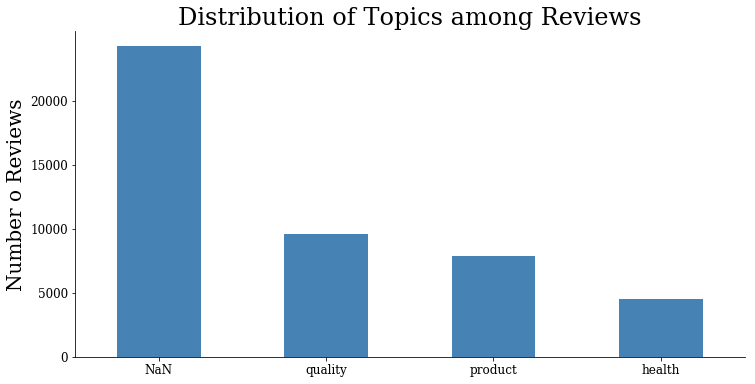

In [1094]:
fig1 = plt.figure(figsize = (6,8))
ax = fig1.add_subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    


groups = ['quality','health','product','other']

plt.yticks(range(0, 20001, 5000), fontsize=12)  
plt.xticks(fontsize=12)  
plt.rc('font', family='serif')
ax = rev_df['topic'].value_counts().plot(kind='bar',
                                    figsize=(12,6),
                                    title="Distribution of Topics among Reviews",
                                    color = 'steelblue')
ax.set_ylabel("Number o Reviews")
for label in ax.get_xticklabels():
    label.set_rotation(0)

Let's create a new dataframe with the processed reviews and their labels:

In [1096]:
df_group = rev_df[rev_df['topic'] != 'NaN']
df_group.reset_index(inplace=True)
df_group.drop('index', axis=1, inplace=True)

In [1097]:
df_group.head()

,process_review,topic
0,i used to love these treats but they must hav...,health
1,my dog does not like them that much and i wil...,quality
2,very hard treat and the worst product from yum...,product
3,my dog loves these but package i received was...,product
4,product ordered for my cat who has recurrent u...,quality


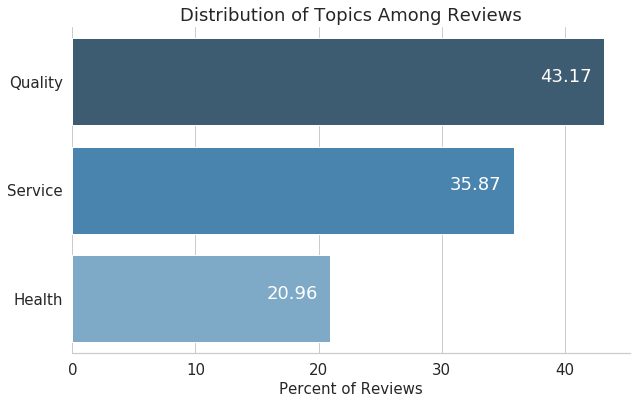

In [409]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10,6))

count = df_group['topic'].value_counts()
percent = 100*count/len(df_group)

# Plot the total crashes
sns.color_palette("PuBuGn_d")
p = sns.barplot(percent, y = ['Quality','Service','Health'],  palette="Blues_d")

# Add informative axis label
ax.set_xlabel("Percent of Reviews", fontsize=15)
ax.set(yticklabels=['Quality','Service','Health'])
ax.set_title("Distribution of Topics Among Reviews", fontsize=18)
sns.despine(left=True)

for b in p.patches:
    width = b.get_width()
    ax.text(width -1  ,
            b.get_y()+b.get_height()/2.,
            '{:1.2f}'.format(width),
            ha="right", fontsize=18, color="white")
        
p.tick_params(labelsize=15)
p.figure.savefig("review_distribution.png")

We're going to focus on reviews that are longer than 10 words in order to make each comment as descriptive as possible.

In [1101]:
def word_count(text):
    counts = len(text.split())
    return counts

In [1102]:
df_group['word_count'] = df_group['process_review'].apply(word_count)

In [1103]:
df_group = df_group[df_group['word_count']>10]
df_group.reset_index(inplace=True)
df_group.drop('index', axis=1,inplace=True)

In [1104]:
df_group.head()

,process_review,topic,word_count
0,i used to love these treats but they must hav...,health,75
1,my dog does not like them that much and i wil...,quality,511
2,very hard treat and the worst product from yum...,product,18
3,my dog loves these but package i received was...,product,13
4,product ordered for my cat who has recurrent u...,quality,35


In [1105]:
df_group.to_csv('df_group.tsv',header=1,index=False, encoding='utf-8', sep='\t')

In [402]:
df_group = pd.read_csv('df_group.tsv',sep = '\t', error_bad_lines=False)

In [1107]:
df_group.head()

,process_review,topic,word_count
0,i used to love these treats but they must hav...,health,75
1,my dog does not like them that much and i wil...,quality,511
2,very hard treat and the worst product from yum...,product,18
3,my dog loves these but package i received was...,product,13
4,product ordered for my cat who has recurrent u...,quality,35


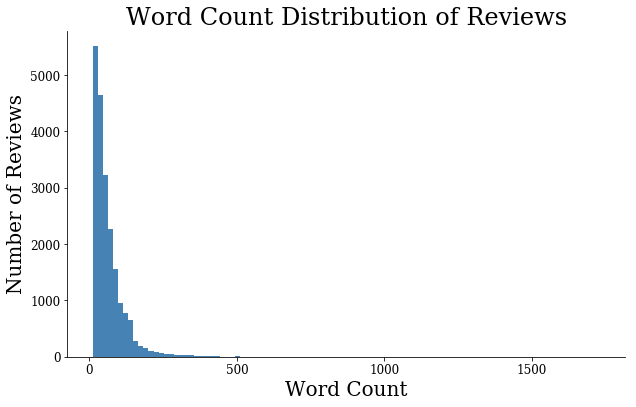

In [1109]:
fig2 = plt.figure(figsize = (10,6))
ax = fig2.add_subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    


ax.set_yticks(range(0, 5001, 1000))    
ax.set_yticklabels(range(0, 5001, 1000))
ax.set_xticks(range(0, 2001, 500))    
ax.set_xticklabels(range(0, 2001, 500))
plt.yticks(fontsize=12) 
plt.xticks(fontsize=12)  
plt.rc('font', family='serif', size=20)

df_group['word_count'].hist(bins=100, color = 'steelblue', grid=False)
#ax.set_xlim(1,1000)
ax.set_xlabel("Word Count")
ax.set_ylabel("Number of Reviews")
ax.set_title('Word Count Distribution of Reviews')
plt.savefig('word_count.png')

Let's also inspect the length of different reviews:

In [1110]:
print(np.percentile(df_group['word_count'], 90))
print(np.percentile(df_group['word_count'], 95))
print(np.percentile(df_group['word_count'], 99))

127.0
159.0
310.0


In [1111]:
df_group.drop('word_count',axis=1, inplace=True)
df_group.head()

,process_review,topic
0,i used to love these treats but they must hav...,health
1,my dog does not like them that much and i wil...,quality
2,very hard treat and the worst product from yum...,product
3,my dog loves these but package i received was...,product
4,product ordered for my cat who has recurrent u...,quality


<a id="D.II.3">

### 3. Create Train and Eval Files

In order to create train and eval datasets, we'll create hash groups for each review and use that to divide the dataset between the two groups.

In [1112]:
df_group['hash'] = pd.Series((abs(hash(tuple(row))) for _, row in df_group.iterrows()))
df_group.head()

,process_review,topic,hash
0,i used to love these treats but they must hav...,health,1411241852688926826
1,my dog does not like them that much and i wil...,quality,9003616572848116650
2,very hard treat and the worst product from yum...,product,2869286342900444198
3,my dog loves these but package i received was...,product,3958807147915836231
4,product ordered for my cat who has recurrent u...,quality,4769814995099392078


In [1113]:
traindf = df_group[df_group['hash']%4 > 0][['topic','process_review']]
evaldf  = df_group[df_group['hash']%4 ==0][['topic','process_review']]

Since there wasn't a huge imbalance between the 3 classes, we'll divide the dataset between the train and eval class with a ratio of 3 to 1. Let's check if we've done just that:

In [1114]:
traindf['topic'].value_counts()

quality    6672
product    5605
health     3223
Name: topic, dtype: int64

In [1115]:
evaldf['topic'].value_counts()

quality    2320
product    1865
health     1142
Name: topic, dtype: int64

Let's save these two file to our directory, and upload them to Google Cloud Storage:

In [1116]:
import os, shutil
DATADIR='data'
shutil.rmtree(DATADIR, ignore_errors=True)
os.makedirs(DATADIR)
traindf.to_csv( os.path.join(DATADIR,'train.tsv'), header=False, index=False, encoding='utf-8', sep='\t')
evaldf.to_csv( os.path.join(DATADIR,'eval.tsv'), header=False, index=False, encoding='utf-8', sep='\t')

In [1117]:
%%bash
gsutil cp data/*.tsv gs://${BUCKET}/

Copying file://data/eval.tsv [Content-Type=text/tab-separated-values]...
Copying file://data/train.tsv [Content-Type=text/tab-separated-values]...       
- [2 files][  6.7 MiB/  6.7 MiB]                                                
Operation completed over 2 objects/6.7 MiB.                                      


<a id="D.II.4">

### 4. Create Python Package for Training the Model

In order to deploy our model to GCP, we need to define a python package with our model and hyperparameters.

In [1271]:
%%writefile Petfood_reviews/trainer/model.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import os
import datetime

#import keras.backend as K
from tensorflow.python.keras.preprocessing import text
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import SpatialDropout1D
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Bidirectional
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.layers import SimpleRNN

from google.cloud import storage

tf.logging.set_verbosity(tf.logging.INFO)

    
CLASSES = {'health': 0, 'quality': 1, 'product':2}  # label-to-int mapping
TOP_K = 100000  # Limit on the number vocabulary size used for tokenization
MAX_SEQUENCE_LENGTH = 150  # Sentences will be truncated/padded to this length
VOCAB_FILE_PATH = None # where vocabulary is saved, dynamically set in train_and_eval function
PADWORD = 'ZYXW'
logs_base_dir= './logs'

"""
Download data from Google Cloud Storage to local disk
    source: string, the GCS URL to download from (e.g. 'gs://bucket/file.csv')
    destination: string, the filename to save as on local disk. MUST be filename
    ONLY, doesn't support folders. (e.g. 'file.csv', NOT 'folder/file.csv')
"""
def download_from_gcs(source, destination):
    search = re.search('gs://(.*?)/(.*)', source)
    bucket_name = search.group(1)
    blob_name = search.group(2)
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    bucket.blob(blob_name).download_to_filename(destination)


"""
Parses raw tsv containing body of reviews and returns (sentences, integer label) pairs
    train_data_path: string, path to tsv containing training data.
        can be a local path or a GCS url (gs://...)
    eval_data_path: string, path to tsv containing eval data.
        can be a local path or a GCS url (gs://...)
  Returns:
      ((train_sentences, train_labels), (test_sentences, test_labels)):  sentences
        are lists of strings, labels are numpy integer arrays
"""
def load_review_data(train_data_path, eval_data_path):
    if train_data_path.startswith('gs://'):
        download_from_gcs(train_data_path, destination='train.tsv')
        train_data_path = 'train.tsv'
    if eval_data_path.startswith('gs://'):
        download_from_gcs(eval_data_path, destination='eval.tsv')
        eval_data_path = 'eval.tsv'

    # Parse CSV using pandas
    column_names = ('label', 'text')
    df_train = pd.read_csv(train_data_path, names=column_names, sep='\t')
    df_eval = pd.read_csv(eval_data_path, names=column_names, sep='\t')

    return ((list(df_train['text']), np.array(df_train['label'].map(CLASSES))),
            (list(df_eval['text']), np.array(df_eval['label'].map(CLASSES))))


"""
Create tf.estimator compatible input function
    texts: [strings], list of sentences
    labels: numpy int vector, integer labels for sentences
    batch_size: int, number of records to use for each train batch
      mode: tf.estimator.ModeKeys.TRAIN or tf.estimator.ModeKeys.EVAL 
  Returns:
      tf.data.Dataset, produces feature and label tensors one batch at a time
"""
def input_fn(texts, labels, batch_size, mode):
    # Convert texts from python strings to tensors
    x = tf.constant(texts)

    # Map text to sequence of word-integers and pad
    x = vectorize_sentences(x)

    # Create tf.data.Dataset from tensors
    dataset = tf.data.Dataset.from_tensor_slices((x, labels))

    # Pad to constant length
    dataset = dataset.map(pad)

    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None #loop indefinitley
        dataset = dataset.shuffle(buffer_size=50000) 
    else:
        num_epochs = 1

    dataset = dataset.repeat(num_epochs).batch(batch_size)
    return dataset

"""
Given an int tensor, remove 0s then pad to a fixed length representation. 
    feature: int tensor 
    label: int. not used in function, just passed through
  Returns:
    (int tensor, int) tuple.
"""
def pad(feature, label):
    # 1. Remove 0s which represent out of vocabulary words
    nonzero_indices = tf.where(tf.not_equal(feature, tf.zeros_like(feature)))
    without_zeros = tf.gather(feature,nonzero_indices)
    without_zeros = tf.squeeze(without_zeros, axis=1)

    # 2. Prepend 0s till MAX_SEQUENCE_LENGTH
    padded = tf.pad(without_zeros, [[MAX_SEQUENCE_LENGTH, 0]])  # pad out with zeros
    padded = padded[-MAX_SEQUENCE_LENGTH:]  # slice to constant length
    return (padded, label)


"""
Given sentences, return an integer representation
    sentences: string tensor of shape (?,), contains sentences to vectorize
    
    Returns:
      Integer representation of the sentence. Word-integer mapping is determined
        by VOCAB_FILE_PATH. Words out of vocabulary will map to 0
"""
def vectorize_sentences(sentences):
    # 1. Remove punctuation
    sentences = tf.regex_replace(sentences, '[[:punct:]]', ' ')

    # 2. Split string tensor into component words
    words = tf.string_split(sentences)
    words = tf.sparse_tensor_to_dense(words, default_value=PADWORD)

    # 3. Map each word to respective integer
    table = tf.contrib.lookup.index_table_from_file(
        vocabulary_file=VOCAB_FILE_PATH,
        num_oov_buckets=0,
        vocab_size=None,
        default_value=0,  # for words not in vocabulary (OOV)
        key_column_index=0,
        value_column_index=1,
        delimiter=',')
    numbers = table.lookup(words)

    return numbers


"""
Builds a CNN model using keras and converts to tf.estimator.Estimator
    model_dir: string, file path where training files will be written
    config: tf.estimator.RunConfig, specifies properties of tf Estimator
    filters: int, output dimension of the layers.
    kernel_size: int, length of the convolution window.
    mbedding_dim: int, dimension of the embedding vectors.
    dropout_rate: float, percentage of input to drop at Dropout layers.
    pool_size: int, factor by which to downscale input at MaxPooling layer.
    embedding_path: string , file location of pre-trained embedding (if used)
        defaults to None which will cause the model to train embedding from scratch
    word_index: dictionary, mapping of vocabulary to integers. used only if
        pre-trained embedding is provided
"""
def keras_CNN_estimator(model_dir,
                    config,
                    embedding_dim = 200,
                    learning_rate = 0.001,
                    dropout_rate = 0.2,
                    filters= 64,
                    kernel_size =3,
                    pool_size=3,
                    embedding_path = None,
                    word_index = None):

    model = models.Sequential()
    num_features = min(len(word_index) + 1, TOP_K)

    # If pre-trained embedding is used add weights to the embeddings layer
    # and set trainable to input is_embedding_trainable flag.
    if embedding_path != None:
        embedding_matrix = get_embedding_matrix(word_index, embedding_path, embedding_dim)
        is_embedding_trainable = True  # set to False to freeze embedding weights

        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=MAX_SEQUENCE_LENGTH))

    model.add(Dropout(rate=dropout_rate))
    model.add(Conv1D(filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              padding='same'))

    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(CLASSES), 
                    kernel_regularizer=tf.keras.regularizers.l1(0.01),
                    activation='softmax'))

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
     
    estimator = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                      model_dir=model_dir,
                                                      config=config)

    return estimator

"""
Builds an LSTM model using keras and converts to tf.estimator.Estimator
    model_dir: string, file path where training files will be written
    config: tf.estimator.RunConfig, specifies properties of tf Estimator
    mbedding_dim: int, dimension of the embedding vectors.
    dropout_rate: float, percentage of input to drop at Dropout layers.
    embedding_path: string , file location of pre-trained embedding (if used)
        defaults to None which will cause the model to train embedding from scratch
    word_index: dictionary, mapping of vocabulary to integers. used only if
        pre-trained embedding is provided
"""

def keras_LSTM_estimator(model_dir,
                    config,
                    learning_rate,
                    dropout_rate,
                    embedding_dim,
                    embedding_path=None,
                    word_index=None):

    model = models.Sequential()
    num_features = min(len(word_index) + 1, TOP_K)

    # If pre-trained embedding is used add weights to the embeddings layer
    # and set trainable to input is_embedding_trainable flag.
    if embedding_path != None:
        embedding_matrix = get_embedding_matrix(word_index, embedding_path, embedding_dim)
        is_embedding_trainable = True  # set to False to freeze embedding weights

        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=MAX_SEQUENCE_LENGTH))

    model.add(SpatialDropout1D(dropout_rate))
    
    model.add(LSTM(embedding_dim*2, dropout=dropout_rate, 
                   recurrent_dropout=0.2,
                  return_sequences=True))
    model.add(LSTM(int(embedding_dim/2), dropout=dropout_rate, 
                   recurrent_dropout=0.2))   
    model.add(Dense(len(CLASSES), 
                    kernel_regularizer=tf.keras.regularizers.l1(0.01),
                    activation='softmax'))

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
     
    estimator = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                      model_dir=model_dir,
                                                      config=config)

    return estimator



"""
Builds a Directional LSTM model using keras and converts to tf.estimator.Estimator
    model_dir: string, file path where training files will be written
    config: tf.estimator.RunConfig, specifies properties of tf Estimator
    mbedding_dim: int, dimension of the embedding vectors.
    dropout_rate: float, percentage of input to drop at Dropout layers.
    embedding_path: string , file location of pre-trained embedding (if used)
        defaults to None which will cause the model to train embedding from scratch
    word_index: dictionary, mapping of vocabulary to integers. used only if
        pre-trained embedding is provided
"""

def keras_BiDirect_estimator(model_dir,
                    config,
                    learning_rate,
                    dropout_rate,
                    embedding_dim,
                    embedding_path=None,
                    word_index=None):

    model = models.Sequential()
    num_features = min(len(word_index) + 1, TOP_K)

    # If pre-trained embedding is used add weights to the embeddings layer
    # and set trainable to input is_embedding_trainable flag.
    if embedding_path != None:
        embedding_matrix = get_embedding_matrix(word_index, embedding_path, embedding_dim)
        is_embedding_trainable = True  # set to False to freeze embedding weights

        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=MAX_SEQUENCE_LENGTH))

    model.add(SpatialDropout1D(dropout_rate))
    
    model.add(Bidirectional(LSTM(embedding_dim*2, 
                               dropout=dropout_rate, 
                               recurrent_dropout=0.2,
                              return_sequences=True)))
    model.add(Bidirectional(LSTM(int(embedding_dim/2),
                               dropout=dropout_rate, 
                               recurrent_dropout=0.2)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(CLASSES),
                    kernel_regularizer=tf.keras.regularizers.l1(0.01),
                    activation='softmax'))


    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
     
    estimator = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                      model_dir=model_dir,
                                                      config=config)

    return estimator

"""
Defines the features to be passed to the model during inference
  Can pass in string text directly. Tokenization done in serving_input_fn 

  Returns: tf.estimator.export.ServingInputReceiver
"""
def serving_input_fn():
    feature_placeholder = tf.placeholder(tf.string, [None])
    features = vectorize_sentences(feature_placeholder)
    return tf.estimator.export.TensorServingInputReceiver(features, feature_placeholder)

"""
Add evaluation metrics
"""


def my_acc(labels, predictions):
    pred_values = predictions['dense']
    return {'acc':tf.keras.metrics.sparse_categorical_accuracy(labels, pred_values)}


"""
Takes embedding for generic vocabulary and extracts the embeddings 
        matching the current vocabulary
    word_index: dict, {key =word in vocabulary: value= integer mapped to that word}
    embedding_path: string, location of the pre-trained embedding file on disk
    embedding_dim: int, dimension of the embedding space
  
  Returns: numpy matrix of shape (vocabulary, embedding_dim) that contains the embedded
      representation of each word in the vocabulary.
"""
def get_embedding_matrix(word_index, embedding_path, embedding_dim):
    # Read the pre-trained embedding file and get word to word vector mappings.
    embedding_matrix_all = {}

    # Download if embedding file is in GCS
    if embedding_path.startswith('gs://'):
        download_from_gcs(embedding_path, destination='embedding.csv')
        embedding_path = 'embedding.csv'

    with open(embedding_path) as f:
        for line in f:  # Every line contains word followed by the vector value
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix_all[word] = coefs

    # Prepare embedding matrix with just the words in our word_index dictionary
    num_words = min(len(word_index) + 1, TOP_K)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i >= TOP_K:
            continue
        embedding_vector = embedding_matrix_all.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


"""
Main orchestrator. Responsible for calling all other functions in model.py

    output_dir: string, file path where training files will be written
    hparams: dict, command line parameters passed from task.py
    
    Returns: starts training and evaluation
"""
def train_and_evaluate(output_dir, hparams):
    # ensure filewriter cache is clear for TensorBoard events file
    tf.summary.FileWriterCache.clear() 
  
    # Load Data
    ((train_texts, train_labels), (test_texts, test_labels)) = load_review_data(
        hparams['train_data_path'], hparams['eval_data_path'])

    # Create vocabulary from training corpus.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Generate vocabulary file from tokenizer object to enable
    # creating a native tensorflow lookup table later (used in vectorize_sentences())
    tf.gfile.MkDir(output_dir) # directory must exist before we can use tf.gfile.open
    global VOCAB_FILE_PATH; VOCAB_FILE_PATH = os.path.join(output_dir,'vocab.txt')
    with tf.gfile.Open(VOCAB_FILE_PATH, 'wb') as f:
        f.write("{},0\n".format(PADWORD))# map padword to 0
        for word, index in tokenizer.word_index.items():
            if index < TOP_K: # only save mappings for TOP_K words
                f.write("{},{}\n".format(word, index))

    # Create estimator
    run_config = tf.estimator.RunConfig(save_checkpoints_steps=100,
                                       save_summary_steps=100)
    
    
    
    if hparams['model_type']=='CNN':
        estimator = keras_CNN_estimator(
            model_dir=output_dir,
            config=run_config,
            learning_rate=hparams['learning_rate'],
            filters = hparams['filters'],
            dropout_rate = hparams['dropout_rate'],
            embedding_dim = hparams['embedding_dim'],
            kernel_size = hparams['kernel_size'],
            pool_size = hparams['pool_size'],
            embedding_path=hparams['embedding_path'],
            word_index=tokenizer.word_index
        )
    elif hparams['model_type']=='LSTM':
            estimator = keras_LSTM_estimator(
                model_dir=output_dir,
                config=run_config,
                learning_rate=hparams['learning_rate'],
                dropout_rate = hparams['dropout_rate'],
                embedding_dim = hparams['embedding_dim'],
                embedding_path=hparams['embedding_path'],
                word_index=tokenizer.word_index
        )
    elif hparams['model_type']=='BiDirect':
            estimator = keras_BiDirect_estimator(
                model_dir=output_dir,
                config=run_config,
                learning_rate=hparams['learning_rate'],
                dropout_rate = hparams['dropout_rate'],
                embedding_dim = hparams['embedding_dim'],
                embedding_path=hparams['embedding_path'],
                word_index=tokenizer.word_index
        )        

    ### Add evaluating metric
    #estimator = tf.contrib.estimator.add_metrics(estimator, my_acc)

    ### Add early stopping
    early_stopping = tf.estimator.experimental.stop_if_no_decrease_hook(
        estimator,
        metric_name='loss',
        max_steps_without_decrease=1000,
        min_steps=100)
    
    
    # Create TrainSpec
    train_steps = hparams['num_epochs'] * len(train_texts) / hparams['batch_size']
    train_spec = tf.estimator.TrainSpec(
        input_fn=lambda:input_fn(
            train_texts,
            train_labels,
            hparams['batch_size'],
            mode=tf.estimator.ModeKeys.TRAIN),
        hooks=[early_stopping],
        max_steps=train_steps
    )

    # Create EvalSpec
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
    eval_spec = tf.estimator.EvalSpec(
        input_fn=lambda:input_fn(
            test_texts,
            test_labels,
            hparams['batch_size'],
            mode=tf.estimator.ModeKeys.EVAL),
        steps=None,
        exporters=exporter,
        start_delay_secs=10,
        throttle_secs=10
    )
    
    # Start training
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    
    

Overwriting Petfood_reviews/trainer/model.py


In [1120]:
%%writefile Petfood_reviews/trainer/task.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
from . import model

if __name__ == '__main__':
    # parse command line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--output_dir',
        help='GCS location to write checkpoints and export models',
        required=True
    )
    parser.add_argument(
        '--train_data_path',
        help='can be a local path or a GCS url (gs://...)',
        required=True
    )
    parser.add_argument(
        '--eval_data_path',
        help='can be a local path or a GCS url (gs://...)',
        required=True
    )
    parser.add_argument(
        '--model_type',
        help='any of the available models: CNN, LSTM, and BiDirect',
        choices=['CNN', 'LSTM', 'BiDirect'],
        required=True
    )
    parser.add_argument(
        '--embedding_path',
        help='OPTIONAL: can be a local path or a GCS url (gs://...). \
              Download from: https://nlp.stanford.edu/projects/glove/',
    )
    parser.add_argument(
        '--num_epochs',
        help='number of times to go through the data, default=10',
        default=10,
        type=float
    )
    parser.add_argument(
        '--batch_size',
        help='number of records to read during each training step, default=128',
        default=128,
        type=int
    )
    parser.add_argument(
        '--learning_rate',
        help='learning rate for gradient descent, default=.001',
        default=.001,
        type=float
    )
    parser.add_argument(
        '--filters',
        help='number of output dimension of the CNN layers, default=64',
        default=64,
        type=int
    )
    parser.add_argument(
        '--dropout_rate',
        help='percentage of input to drop at Dropout layers, default=.2',
        default=.2,
        type=float
    )   
    parser.add_argument(
        '--embedding_dim',
        help='dimension of the embedding vectors, default=200',
        default=200,
        type=int
    )           
    parser.add_argument(
        '--kernel_size',
        help='length of the convolution window, default=3',
        default=3,
        type=int
    )                              
    parser.add_argument(
        '--pool_size',
        help='factor by which to downscale input at MaxPooling layer, default=3',
        default=3,
        type=int
    )                     
  
    
    args, _ = parser.parse_known_args()
    hparams = args.__dict__
    output_dir = hparams.pop('output_dir')
    
    model.train_and_evaluate(output_dir, hparams)

Overwriting Petfood_reviews/trainer/task.py


In [53]:
%%writefile Petfood_reviews/trainer/__init__.py

### init file ###

Writing Petfood_reviews/trainer/__init__.py


<a id="D.II.5">

### 5. TEST RUN

Let's run our model locally just to check if it's working fine before submitting it to the cloud.

In [1267]:
%%bash
pip install google-cloud-storage --user
rm -rf review_trained
gcloud ai-platform local train \
   --module-name=trainer.task \
   --package-path=${PWD}/Petfood_reviews/trainer \
   -- \
   --output_dir=${PWD}/review_trained \
   --train_data_path=${PWD}/data/train.tsv \
   --eval_data_path=${PWD}/data/eval.tsv \
   --model_type='LSTM'\
   --num_epochs=0.1






INFO:tensorflow:TF_CONFIG environment variable: {u'environment': u'cloud', u'cluster': {}, u'job': {u'args': [u'--output_dir=/home/jupyter/review_trained', u'--train_data_path=/home/jupyter/data/train.tsv', u'--eval_data_path=/home/jupyter/data/eval.tsv', u'--model_type=LSTM', u'--num_epochs=0.1'], u'job_name': u'trainer.task'}, u'task': {}}
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Using the Keras model provided.
2020-02-10 00:26:18.660690: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-02-10 00:26:18.661373: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5568175b5e20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-02-10 00:26:18.661413: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor d

<a id="D.II.6">

### 6. Train on Cloud

<a id="D.II.6.i">

### i. CNN Model
Skip to see the [result](#cnn).

In [1138]:
%%bash
OUTDIR=gs://${BUCKET}/insight_project_cnn/trained_model
JOBNAME=reviews_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud --verbosity=debug ai-platform jobs submit training $JOBNAME \
 --region=$REGION \
 --module-name=trainer.task \
 --package-path=${PWD}/Petfood_reviews/trainer \
 --job-dir=$OUTDIR \
 --scale-tier=BASIC_GPU \
 --runtime-version=1.15 \
 --\
 --output_dir=$OUTDIR \
 --train_data_path=gs://${BUCKET}/train.tsv \
 --eval_data_path=gs://${BUCKET}/eval.tsv \
 --embedding_path=gs://${BUCKET}/glove.6B.200d.txt \
 --model_type='CNN'\
 --num_epochs=20

gs://petfood_review/insight_project_cnn/trained_model us-central1 reviews_200209_021833
jobId: reviews_200209_021833
state: QUEUED


Removing gs://petfood_review/insight_project_cnn/trained_model/checkpoint#1581214107887325...
Removing gs://petfood_review/insight_project_cnn/trained_model/eval/#1581213862702572...
Removing gs://petfood_review/insight_project_cnn/trained_model/eval/events.out.tfevents.1581213862.cmle-training-4022713395243452220#1581214113488585...
Removing gs://petfood_review/insight_project_cnn/trained_model/events.out.tfevents.1581213828.cmle-training-4022713395243452220#1581214122566247...
Removing gs://petfood_review/insight_project_cnn/trained_model/export/exporter/#1581213865267654...
Removing gs://petfood_review/insight_project_cnn/trained_model/export/#1581213864994264...
Removing gs://petfood_review/insight_project_cnn/trained_model/export/exporter/1581214030/#1581214036933418...
Removing gs://petfood_review/insight_project_cnn/trained_model/export/exporter/1581214030/assets/#1581214037171297...
Removing gs://petfood_review/insight_project_cnn/trained_model/export/exporter/1581214030/assets

In [449]:
#%%bash
#gcloud ai-platform jobs stream-logs reviews_200209_021833

In [502]:
def find_acc_log():
    log_dict = {}
    global_step = []
    accuracy = []
    loss_val = []
    with open('CNN_logs.txt', 'r') as log_file:
        for line in log_file:
            if re.search("sparse_categorical_accuracy = ", line) is not None:
                acc = re.findall("sparse_categorical_accuracy = (.*)", line)
                step = re.findall("global_step = (\d+)", line)
                loss = re.findall("loss = (.*),", line)
                global_step.append(step)
                accuracy.append(acc)
                loss_val.append(loss)
    log_dict['step'] = global_step
    log_dict['accuracy'] = accuracy
    log_dict['loss'] = loss_val
    return log_dict

In [437]:
#%load_ext tensorboard

In [504]:
#%%bash
#OUTDIR=gs://petfood_review/insight_project_cnn/trained_model
#tensorboard --logdir=OUTDIR

<a id='cnn'></a>

**global step 2422: global_step = 2422, loss = 0.6730147, sparse_categorical_accuracy = 0.9110193**

**training time**= 15 minutes

<a id="D.II.6.ii">

### ii. LSTM Model

skip to [result](#lstm).

In [1268]:
%%bash
OUTDIR=gs://${BUCKET}/insight_project_lstm/trained_model
JOBNAME=reviews_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud --verbosity=debug ai-platform jobs submit training $JOBNAME \
 --region=$REGION \
 --module-name=trainer.task \
 --package-path=${PWD}/Petfood_reviews/trainer \
 --job-dir=$OUTDIR \
 --scale-tier=BASIC_GPU \
 --runtime-version=1.15 \
 --\
 --output_dir=$OUTDIR \
 --train_data_path=gs://${BUCKET}/train.tsv \
 --eval_data_path=gs://${BUCKET}/eval.tsv \
 --embedding_path=gs://${BUCKET}/glove.6B.200d.txt \
 --model_type='LSTM' \
 --num_epochs=20

gs://petfood_review/insight_project_lstm/trained_model us-central1 reviews_200210_003633
jobId: reviews_200210_003633
state: QUEUED


Removing gs://petfood_review/insight_project_lstm/trained_model/checkpoint#1581218598102441...
Removing gs://petfood_review/insight_project_lstm/trained_model/eval/#1581217257517343...
Removing gs://petfood_review/insight_project_lstm/trained_model/eval/events.out.tfevents.1581217257.cmle-training-9634952068735405832#1581218607303796...
Removing gs://petfood_review/insight_project_lstm/trained_model/events.out.tfevents.1581217192.cmle-training-9634952068735405832#1581218600277336...
Removing gs://petfood_review/insight_project_lstm/trained_model/export/#1581217259983412...
Removing gs://petfood_review/insight_project_lstm/trained_model/export/exporter/1581218403/#1581218411301350...
Removing gs://petfood_review/insight_project_lstm/trained_model/export/exporter/#1581217260248594...
Removing gs://petfood_review/insight_project_lstm/trained_model/export/exporter/1581218403/assets/#1581218411839803...
Removing gs://petfood_review/insight_project_lstm/trained_model/export/exporter/15812184

In [506]:
#%%bash
#gcloud ai-platform jobs stream-logs reviews_200210_003633

<a id='lstm'></a>

**global step 2422: global_step = 2422, loss = 0.6713934, sparse_categorical_accuracy = 0.95963955**

**training time**: 45 minutes

<a id="D.II.6.iii">

### iii. Bidirectional LSTM Model

See the [result](#bidirect).

In [1148]:
%%bash
OUTDIR=gs://${BUCKET}/insight_project_bidirect/trained_model
JOBNAME=reviews_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud --verbosity=debug ai-platform jobs submit training $JOBNAME \
 --region=$REGION \
 --module-name=trainer.task \
 --package-path=${PWD}/Petfood_reviews/trainer \
 --job-dir=$OUTDIR \
 --scale-tier=BASIC_GPU \
 --runtime-version=1.15 \
 --\
 --output_dir=$OUTDIR \
 --train_data_path=gs://${BUCKET}/train.tsv \
 --eval_data_path=gs://${BUCKET}/eval.tsv \
 --embedding_path=gs://${BUCKET}/glove.6B.200d.txt \
 --model_type='BiDirect' \
 --num_epochs=20

gs://petfood_review/insight_project_bidirect/trained_model us-central1 reviews_200209_043659
jobId: reviews_200209_043659
state: QUEUED


Removing gs://petfood_review/insight_project_bidirect/trained_model/checkpoint#1581220909540367...
Removing gs://petfood_review/insight_project_bidirect/trained_model/eval/#1581220106457702...
Removing gs://petfood_review/insight_project_bidirect/trained_model/eval/events.out.tfevents.1581220106.cmle-training-11148730246480121485#1581220928817902...
Removing gs://petfood_review/insight_project_bidirect/trained_model/events.out.tfevents.1581219923.cmle-training-11148730246480121485#1581220911885438...
Removing gs://petfood_review/insight_project_bidirect/trained_model/export/exporter/#1581220109202564...
Removing gs://petfood_review/insight_project_bidirect/trained_model/export/#1581220108922465...
Removing gs://petfood_review/insight_project_bidirect/trained_model/export/exporter/1581220272/#1581220279933637...
Removing gs://petfood_review/insight_project_bidirect/trained_model/export/exporter/1581220272/saved_model.pb#1581220280709983...
Removing gs://petfood_review/insight_project_bi

In [528]:
%%bash
#gcloud ai-platform jobs stream-logs reviews_200209_043659

<a id='bidirect'></a>

**global step 2422: global_step = 2422, loss = 0.68818426, sparse_categorical_accuracy = 0.9408673**

**training time** = 1 hour 10 minutes

**Saving dict for global step 1940: global_step = 1940, loss = 0.60588276, sparse_categorical_accuracy = 0.94460434**

Let's visualize the trends of evaluation accuracy as a function of global training step to check for overfitting:

In [522]:
def find_acc_log(log):
    log_dict = {}
    global_step = []
    accuracy = []
    loss_val = []
    with open(log, 'r') as log_file:
        for line in log_file:
            if re.search("sparse_categorical_accuracy = ", line) is not None:
                acc = re.findall("sparse_categorical_accuracy = (.*)", line)
                step = re.findall("global_step = (\d+)", line)
                loss = re.findall("loss = (.*),", line)
                global_step.append(step[0])
                accuracy.append(acc[0])
                loss_val.append(loss[0])
    log_dict['step'] = global_step
    log_dict['accuracy'] = accuracy
    log_dict['loss'] = loss_val
    return log_dict

In [523]:
cnn_log = find_acc_log("CNN_logs.txt")
lstm_log = find_acc_log("lstm_log.txt")
lstmbi_log = find_acc_log("lstm_bidirect.txt")

In [578]:
logs = {"CNN":cnn_log['accuracy'], "LSTM":lstm_log['accuracy'], "biLSTM": lstmbi_log['accuracy']}
df = pd.DataFrame.from_dict(logs)
df.index = [cnn_log['step']]

In [579]:
df = df.apply(pd.to_numeric)

In [580]:
df.reset_index(inplace=True)

In [610]:
df['level_0'] = df['level_0'].astype('int')

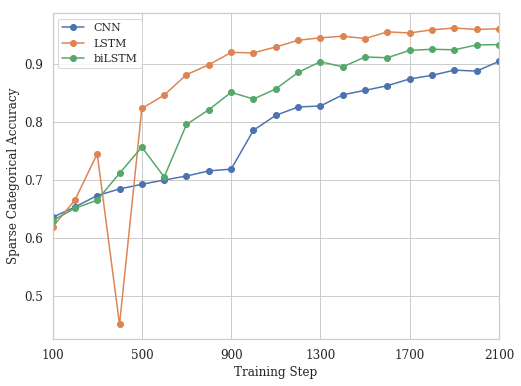

In [631]:
plt.figure(figsize = (8,6))

plt.plot(df["level_0"], df["CNN"], marker='o') 
plt.plot(df["level_0"], df["LSTM"], marker='o')
plt.plot(df["level_0"], df["biLSTM"], marker='o')


plt.xticks(range(100, 2101, 400))  
plt.xlim(100,2100)

plt.yticks(fontsize=12) 
plt.xticks(fontsize=12)  

plt.xlabel("Training Step")
plt.ylabel("Sparse Categorical Accuracy")
plt.legend()

plt.savefig('accuracy.png')

Since the accuracies on validation dataset do not decrease at later time steps, there does not appear to be any signs of overfitting.

<a id="D.II.7">

### 7. Deploy Model

Since the LSTM model outperformed the other two, that's the model that is ultimately deployed to Google AI Platform.

In [1274]:
%%bash
MODEL_NAME="insight_project_lstmII"
MODEL_VERSION="v3"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/insight_project_lstm/trained_model/export/exporter/ | tail -1)
#gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME} --quiet
#gcloud ai-platform models delete ${MODEL_NAME}
#gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=1.15

Creating version (this might take a few minutes)......
.................................................................................................................................................................................................................................................................................................................................done.


<a id="D.II.8">

### 8. Prediction

Let's see how our model fares on the prediciton front! For that, we'll take 3 examples from the eval file in oder to see how the model does on predicting their labels.

In [1178]:
#Product
text1 = evaldf.iloc[300]['process_review']
label1 = evaldf.iloc[300]['topic']

#Health
text2 = evaldf.iloc[400]['process_review']
label2 = evaldf.iloc[400]['topic']

#Quality
text3 = evaldf.iloc[2100]['process_review']
label3 = evaldf.iloc[2100]['topic']

In [1179]:
print('Label: {}\n Review:{}'.format(label1,text1))
print('Label: {}\n Review:{}'.format(label2,text2))
print('Label: {}\n Review:{}'.format(label3,text3))

Label: product
 Review:we were very disappointed to find this come without the applicator tip pictured  photo 3 4   we needed to buy a dropper separately to fill and use  as far as whether it clears up ear mite issues  after the suggested 2 wk application period using an ear dropper  we got separately  did not work as well as the oral syringe  do not administer orally  to squirt it into the ear  in the end we used treatment from sentry brand for better results 
Label: health
 Review:the greenies were very old looking  greenies are a dark green  however  the ones i received were light green with specs of dark green  my dog has a greenie everyday and never an issue  when i gave her the greenies from this shipment she had diarrhea for the couple of days i gave them to her  ended up throwing them away and went to pet smart and bought from there and she had no issues with those and they were dark green as always 
Label: quality
 Review:my cats do not like these  not sure why  would not purc

In [1275]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

# JSON format the requests
requests = ([text1]+[text2]+[text3])
requests = [x.lower() for x in requests] 
request_data = {'instances': requests}

# Authenticate and call CMLE prediction API 
credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials,
            discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'insight_project_lstmII', 'v3')
response = api.projects().predict(body=request_data, name=parent).execute()

# Format and print response
for i in range(len(requests)):
  print('\n{}'.format(requests[i]))
  print(' health    : {}'.format(response['predictions'][i]['dense'][0]))
  print(' quality   : {}'.format(response['predictions'][i]['dense'][1]))
  print(' service   : {}'.format(response['predictions'][i]['dense'][2]))


we were very disappointed to find this come without the applicator tip pictured  photo 3 4   we needed to buy a dropper separately to fill and use  as far as whether it clears up ear mite issues  after the suggested 2 wk application period using an ear dropper  we got separately  did not work as well as the oral syringe  do not administer orally  to squirt it into the ear  in the end we used treatment from sentry brand for better results 
 health    : 0.011466864496469498
 quality   : 0.012292907573282719
 service   : 0.9762402772903442

the greenies were very old looking  greenies are a dark green  however  the ones i received were light green with specs of dark green  my dog has a greenie everyday and never an issue  when i gave her the greenies from this shipment she had diarrhea for the couple of days i gave them to her  ended up throwing them away and went to pet smart and bought from there and she had no issues with those and they were dark green as always 
 health    : 0.962423

<a id="E">

## E. Test the Dictionary on New Dataset

In [415]:
def get_item_id(url):
    '''
    This function extracts the item id and product name that appear in the url
    of a specific pet food.
    '''
    item_id = re.findall("/dp/(\d+)", url)
    product_name = re.findall("com/(.*)/", url)
    return item_id[0], product_name[0].split('/')[0]


def get_reviews(request_url):
    
    item_id, product_name = get_item_id(request_url)
    reviews = list()
    if item_id is None:
        return reviews
    
    product_reviews_link = get_product_reviews_url(item_id, product_name)

    so = get_soup(product_reviews_link)
    
    max_page_number = so.find(attrs={"class":"ugc-list__content--pagination"}).text.strip().split()[3]
    
    print(max_page_number)
    
    if max_page_number is None:
        return reviews
    
    max_page_number = int(max_page_number) if max_page_number else 1
    max_page_number *= 0.1  # displaying 10 results per page. So if 663 results then ~66 pages.
    max_page_number = math.ceil(max_page_number)
    print(max_page_number)
    
    for page_number in range(1, max_page_number + 1):
        print(page_number)
        if page_number >=1:
            product_reviews_link = get_product_reviews_url(item_id,product_name,page_number)
            so = get_soup(product_reviews_link)

        reviews_list = so.find_all('li', {'itemprop': 'review'})
        
        if len(reviews_list) == 0:
            break
            
        for review in reviews_list:
            body = review.find(attrs={'class':'ugc-list__review__display'}).text.strip()
            rev_id = review.get('data-content-id')
            try:
                helpful = review.find(attrs={'data-ga-action':'like'}).text.strip()
            except:
                helpful = '0'
                
            reviews.append({'id':rev_id, 'body': body, 'helpful_votes':helpful})
            

    return reviews

In [416]:
revs = get_reviews("https://www.chewy.com/hills-science-diet-adult-sensitive/dp/34037")

42
5
1
2
3
4
5


In [417]:
revs_df = pd.DataFrame(revs)

In [418]:
revs_df.head()

,body,helpful_votes,id
0,We bought this food hoping the promising descr...,0,217499213
1,Unfortunately I did not realize this was not f...,0,216884557
2,I have been using a salmon and sweet potato di...,2,216600444
3,We switched from blue Buffalo to hills and Rug...,1,215994690
4,My dog wouldn't eat it :-( it's more expensive...,0,214055376


In [419]:
revs_df['process_review'] = revs_df['body'].apply(clean_text)

In [422]:
quality_rows, health_rows, product_rows = topic_dict(revs_df)

In [423]:
import itertools
total = itertools.chain(quality_rows,health_rows, product_rows)
print(len(set(total)))

revs_df['topic']='NaN'
for i in range(len(revs_df)):
    if i in health_rows:
        revs_df.loc[revs_df.index==i, 'topic'] = 'health'
    elif i in quality_rows:
        revs_df.loc[revs_df.index==i, 'topic'] = 'quality'
    elif i in product_rows:
        revs_df.loc[revs_df.index == i,'topic'] = 'product'

29


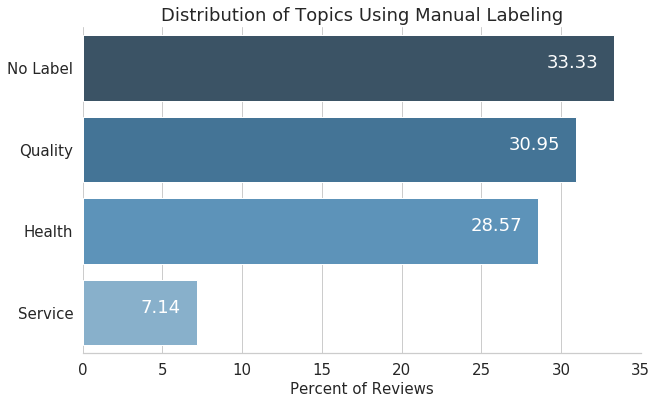

In [435]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10,6))

count = revs_df['topic'].value_counts()
percent = 100*count/len(revs_df)

# Plot the total crashes
sns.color_palette("PuBuGn_d")
p = sns.barplot(percent, y = ['No Label','Quality','Health','Service'],  palette="Blues_d")

# Add informative axis label
ax.set_xlabel("Percent of Reviews", fontsize=15)
ax.set(yticklabels=['No Label','Quality','Health','Service'])
ax.set_title("Distribution of Topics Using Manual Labeling", fontsize=18)
sns.despine(left=True)

for b in p.patches:
    width = b.get_width()
    ax.text(width -1  ,
            b.get_y()+b.get_height()/2.,
            '{:1.2f}'.format(width),
            ha="right", fontsize=18, color="white")
        
p.tick_params(labelsize=15)
p.figure.savefig("chewy_test.png")
#fig.tight_layout()

In [426]:
len(revs_df[revs_df['topic']=='NaN'])/len(revs_df)

0.30952380952380953

We can see that using the naive approach of labeling the reviews using a dictionary of words fails to label about 30 percent of the reviews, whereas an RNN model can pick up more nuanced information from the structure of the sentence to do the same job.

In [1279]:
def get_prediction(url_link):
    tic = time.clock()
    reviews_doc = get_reviews(url_link)
    reviews = []
    orig_reviews = []
    ids = []
    helpful = []
    for i in range(len(reviews_doc)):
        review = reviews_doc[i]['body']
        orig_reviews.append(review)
        rev_process = clean_text(review)
        reviews.append(rev_process)
        rev_id = reviews_doc[i]['id']
        ids.append(rev_id)
        rev_help = reviews_doc[i]['helpful_votes']
        helpful.append(rev_help)
        
    helpful = [1 if el=='One' else el for el in helpful]
    request_data = {'instances': reviews}
    #request_json = request.get_json(silent=True)

    # Authenticate and call CMLE prediction API
    credentials = GoogleCredentials.get_application_default()
    api = discovery.build('ml', 'v1', credentials=credentials,discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')
    parent = 'projects/%s/models/%s/versions/%s' % ('petfoodrecommend', 'insight_project_lstmII', 'v3')
    response = api.projects().predict(body=request_data, name=parent).execute()

    # Format response
    reviews_class = []
    for i in range(len(reviews)):
        response_list = response['predictions'][i]['dense']
        group = response_list.index(max(response_list))
        reviews_class.append(group)
    
    dict_class = dict(zip(ids,reviews_class))
    dict_help = dict(zip(ids,helpful))
    dict_review = dict(zip(ids,orig_reviews))
    
    class_id = defaultdict(list) 
    for key, val in sorted(dict_class.items()): 
        class_id[val].append(key) 
        
    max_help = 0
    final_dict = {}
    for key in class_id.keys():
        for id_val in class_id[key]:
            max_help_val = dict_help[id_val]
            if int(max_help_val)>max_help:
                max_help = int(max_help_val)
                most_help_id = id_val
        
        final_dict[key] = most_help_id
        max_help = 0
        
    class_0 = 100 * reviews_class.count(0)/len(reviews_class)
    class_1 = 100 * reviews_class.count(1)/len(reviews_class)
    class_2 = 100 * reviews_class.count(2)/len(reviews_class)


    result_dict = {}
    inside_dict = {}
    for key in final_dict:
        if key==0:
            inside_dict['percent'] = class_0
        elif key==1:
            inside_dict['percent'] = class_1
        elif key==2:
            inside_dict['percent'] = class_2
            
        inside_dict['helpful_id'] = final_dict[key]
        inside_dict['helpful_rev'] = dict_review[final_dict[key]]
        result_dict[key] = inside_dict
        inside_dict = {}
        
        for i in range(3):
            inside={}
            if i not in list(result_dict.keys()):
                inside['helpful_rev'] = 'There are no reviews in this category!'
                inside['percent'] = 0
                result_dict[i] = inside
            
    toc = time.clock()
    print("Elapsed time: ", toc-tic )
    return reviews_class, result_dict, len(reviews_class)

In [1282]:
result_dict = get_prediction('https://www.chewy.com/hills-science-diet-adult-sensitive/dp/34037')

5
1
2
3
4
5
Elapsed time:  0.5586510000011913
